In [1]:
from all_functions import *
from sklearn.metrics import mean_absolute_percentage_error as mape
from aeon.visualisation import plot_series

In [2]:
horizon = 12
window = 12
df = pd.read_csv("../datasets/venda/mensal/uf/gasolinac/mensal_pr_gasolinac.csv", header=0, parse_dates=['timestamp'], sep=";", date_parser=custom_parser)
df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
df = df.set_index('timestamp',inplace=False)
df.index = df.index.to_period('M')
series = df['m3']
all_series_test = []
train, test = train_test_stats(series, horizon)
train_val, test_val = train_test_stats(train, horizon)

train_val_normal = transform_train(train_val, format="normal")
train_normal = transform_train(train, format="normal")
all_series_test.append(("normal", train_val_normal, train_normal))

#series sem sazonalidade
train_val_ds = transform_train(train_val, format="deseasonal")
train_tf_ds = transform_train(train, format="deseasonal")

all_series_test.append(("deseasonal", train_val_ds, train_tf_ds))

#series deseasonal + log transform
train_val_ds_log = transform_train(train_val, format="deseasonal-log")
train_tf_ds_log = transform_train(train, format="deseasonal-log")
all_series_test.append(("deseasonal-log", train_val_ds_log, train_tf_ds_log))

#series sem sazonalidade e sem tendencia
train_val_ds_diff = transform_train(train_val, format="deseasonal-diff")
train_tf_ds_diff = transform_train(train, format="deseasonal-diff")
all_series_test.append(("deseasonal-diff", train_val_ds_diff, train_tf_ds_diff))

#series sem tendencia
train_val_diff = transform_train(train_val, format="diff")
train_tf_diff = transform_train(train, format="diff")
all_series_test.append(("diff", train_val_diff, train_tf_diff))

#series log transform
train_val_log = transform_train(train_val, format="log")
train_tf_log = transform_train(train, format="log")
all_series_test.append(("log", train_val_log, train_tf_log))

#series log transform + diff
train_val_log_diff = transform_train(train_val, format="log-diff")
train_tf_log_diff = transform_train(train, format="log-diff")
all_series_test.append(("log-diff", train_val_log_diff, train_tf_log_diff))

path_results_arima = './results/arima/rolling'
derivado = 'gasolinac'
uf = 'PR'
titulo = f"{derivado} em {uf}"
all_preds = []
for f, train_val, train_test in all_series_test:
    arima_order = get_arima_param(path_results_arima, derivado, uf, f)
    forecast, preds_real, final_order = fit_arima_train(train_test, train, arima_order, horizon, format=f)

    rmse_result = rmse(test, preds_real)
    mape_result = mape(test, preds_real)
    pocid_result = pocid(test, preds_real)
    pbe_result = pbe(test, preds_real)
    mcpm_result = mcpm(rmse_result, mape_result, pocid_result)
    print(f'{f}: {mcpm_result}')
    all_preds.append((f, preds_real))

plot_series(test, all_preds[0][1], all_preds[1][1], all_preds[2][1], all_preds[3][1], all_preds[4][1], all_preds[5][1], all_preds[6][1],
            labels=["Test", all_preds[0][0], all_preds[1][0], all_preds[2][0],all_preds[3][0], all_preds[4][0], all_preds[5][0], all_preds[6][0]],
            title=titulo
            )


normal: 357091.02644833474
deseasonal: 206746.51430447295


KeyboardInterrupt: 

In [21]:
import os
def get_predictions_uf(pasta, start_date, transformations=['normal', 'deseasonal', 'log']):
    if not start_date:
        print_log("start_date must have a value")
        return
    resultado_final_por_uf = {}
    if os.path.isdir(pasta):
        for arquivo in os.listdir(pasta):
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta, arquivo)
                df = pd.read_csv(caminho_arquivo, delimiter=';')
                
                df_filtrado = df[df['DATA'].isin(transformations) & df['SAVED MODEL'].notna() & df['UF'].notna()]
                for indice, linha in df_filtrado.iterrows():
                    # caminho_pickle = linha['SAVED MODEL']
                    
                    predictions = [linha[f'P{i}'] for i in range(1, 13)]

                    index = pd.period_range(start=start_date, periods=len(predictions), freq='M')

                    serie_predicoes = pd.Series(predictions, index=index, name='m3')

                    # print(predictions)
                    uf = linha['UF']
                    if uf not in resultado_final_por_uf:
                        resultado_final_por_uf[uf] = []
                    resultado_final_por_uf[uf].append((linha['DATA'], serie_predicoes))
    return resultado_final_por_uf

def get_train_test_uf(initial_path, derivado, uf, tipo="mensal"):
    df = pd.read_csv(f"{initial_path}/uf/{derivado}/{tipo}_{uf.lower()}_{derivado}.csv", header=0, parse_dates=['timestamp'], sep=";", date_parser=custom_parser)
    df['timestamp']=pd.to_datetime(df['timestamp'],infer_datetime_format=True)
    df = df.set_index('timestamp',inplace=False)
    df.index = df.index.to_period('M')
    series = df['m3']
    train, test = train_test_stats(series, horizon)
    return train, test


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

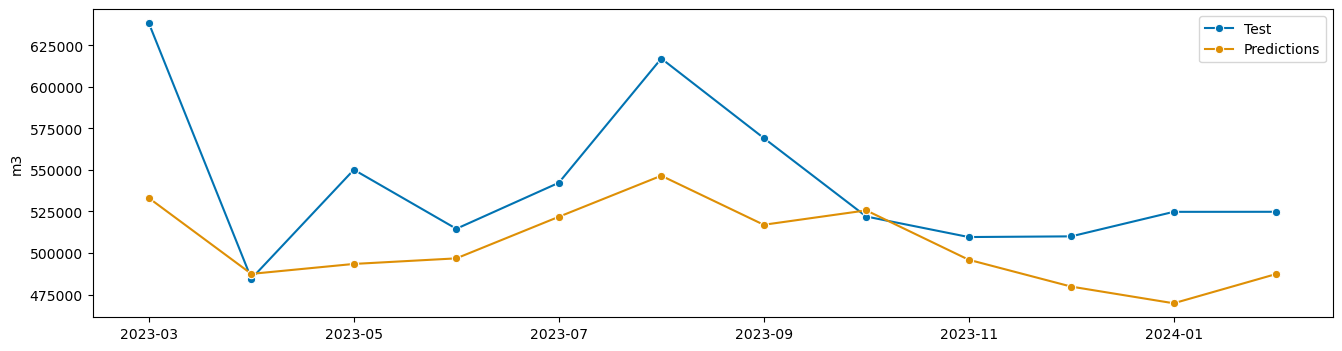

In [25]:
from all_functions import *
import os
import pickle
from sklearn.ensemble import VotingRegressor
from VotingCombination import VotingCombination
from aeon.visualisation import plot_series


pastas = [
        #   './Statistics_and_Seq2Seq/results/arima/rolling/gasolinac',
          './results/arima/rolling/oleodiesel',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/etanolhidratado',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/gasolinadeaviacao',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/glp',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/oleocombustivel',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/querosenedeaviacao',
        #   './Statistics_and_Seq2Seq/results/arima/rolling/queroseneiluminante'
          ]



# for pasta in pastas:
    
uf = 'PR'
derivado = "oleodiesel"
pasta = './results/arima/rolling/oleodiesel'
initial_path = "../datasets/venda/mensal/"
horizon = 12


train, test = get_train_test_uf(initial_path, derivado, uf)

resultado_final_por_uf = get_predictions_uf(pasta, start_date=test.index[0])

voting = VotingCombination(resultado_final_por_uf[uf], combination='oracle')

combined_preds = voting.predict(test)

plot_series(test, combined_preds, labels=["Test", "Predictions"])

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='m3'>)

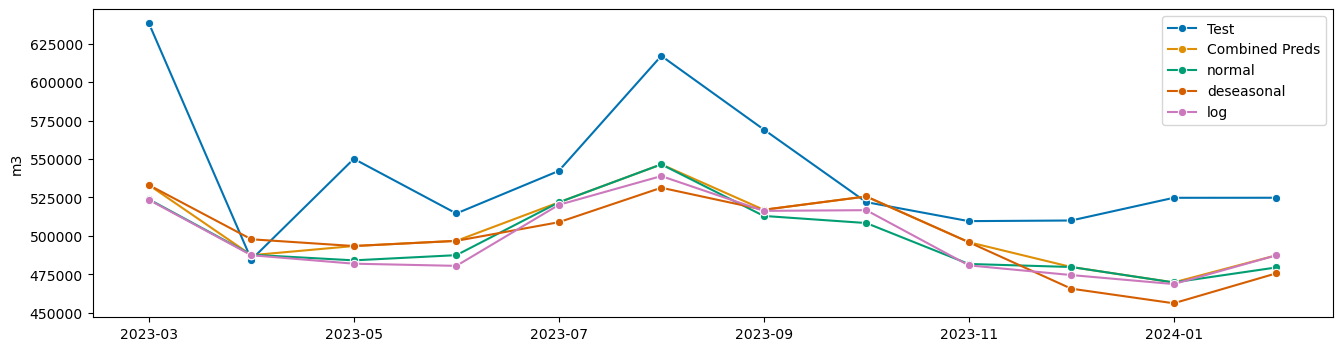

In [7]:
preds = resultado_final_por_uf[uf]
labels = [t[0] for t in preds]
series_temporais = [t[1] for t in preds]
series_temporais.insert(0, combined_preds)
series_temporais.insert(0, test)
labels.insert(0, "Combined Preds")
labels.insert(0, "Test")
plot_series(*series_temporais, labels=labels)

In [ ]:
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
   
def adf_summary(diff_series):
    summary = []
    
    for i in diff_series:
        a, b, c, d, e, f = adfuller(diff_series[i].dropna())
        g, h, i = e.values()
        results = [a, b, c, d, g, h, i]
        summary.append(results)
    
    columns = ["Test Statistic", "p-value", "#Lags Used", "No. of Obs. Used",
               "Critical Value (1%)", "Critical Value (5%)", "Critical Value (10%)"]
    index = diff_series.columns
    summary = pd.DataFrame(summary, index=index, columns=columns)
    
    return summary

def get_pacf(series):
    df_datetime = series.copy()
    df_datetime.index = df_datetime.index.to_timestamp()
    return pacf(df_datetime.dropna(), alpha=0.05, method='ywm')

def get_ar_terms(series):
    df_sp_p = pd.DataFrame()
    AR = []
    for i in ps:
        # unpack the results into PACF and their CI
        PACF, PACF_ci = get_pacf(series[i])
        
        # subtract the upper and lower limits of CI by ACF to centre CI at zero
        PACF_ci_ll = PACF_ci[:,0] - PACF
        PACF_ci_ul = PACF_ci[:,1] - PACF
        
        # find positions of significant spikes ~ possible value of p & P
        sp1 = np.where(PACF < PACF_ci_ll)[0]
        sp2 = np.where(PACF > PACF_ci_ul)[0]
        
        # PACF values of the significant spikes
        sp1_value = abs(PACF[PACF < PACF_ci_ll])
        sp2_value = PACF[PACF > PACF_ci_ul]
        
        # store values to dataframe
        sp1_series = pd.Series(sp1_value, index=sp1)
        sp2_series = pd.Series(sp2_value, index=sp2)
        df_sp_p = pd.concat((df_sp_p, sp1_series, sp2_series), axis=1)

In [9]:
sarima_order = get_arima_param(path_results_arima, derivado, uf, "diff")
model = ARIMA(order=sarima_order, 
                seasonal_order=(12,0,14,24),
                # suppress_warnings=True
            )
model.fit(train_tf_diff)
predictions = model.predict(fh=[i for i in range(1, horizon+1)] )
preds_real = reverse_transform_norm_preds(predictions, train, format="diff")

rmse_result = rmse(test, preds_real)

KeyboardInterrupt: 